### Introduction

In this kernel I use XGBRegressor from XGBoost library to predict future prices of stocks using technical indicator as features. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to [articles on Investopedia](https://www.investopedia.com/technical-analysis-4689657) or [this notebook of mine](https://www.kaggle.com/mtszkw/analysis-and-technical-indicators-for-trading-etfs) where I introduce and visualize various technical analysis concepts.

In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

### Read historical prices

I read historical data frame for a chosen stock (e.g. CERN) which I am going to analyze. New York Stock Exchange dataset provides day by day price history gathered over more than 10 years. I decided to crop the time frame and start it from a year 2010 to reduce amount of data to be processed.

Removing rows is then followed by reindexing the data frame to keep it clean.

In [ ]:


df = pd.read_csv("../Dataset/GAS.csv")

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)
df = df[(df['date'].dt.year >= 2012)].copy()
df.index = range(len(df))

df.head()

date   close  volume      open      high       low
0 2012-01-03  4.7478  206450  4.930408  4.930408  4.747800
1 2012-01-04  4.6337  177420  4.656526  4.656526  4.588048
2 2012-01-05  4.6109  165210  4.565248  4.656552  4.565248
3 2012-01-06  4.5196  298140  4.610905  4.610905  4.496774
4 2012-01-09  4.6565  367990  4.519544  4.679326  4.519544

### OHLC Chart

I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day. In my previous notebook (linked above) I explain importance of OHLC and Volume charts in technical analysis.

In [3]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.date,
                      open=df.open,
                      high=df.high,
                      low=df.low,
                      close=df.close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.date, y=df.volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

### Decomposition

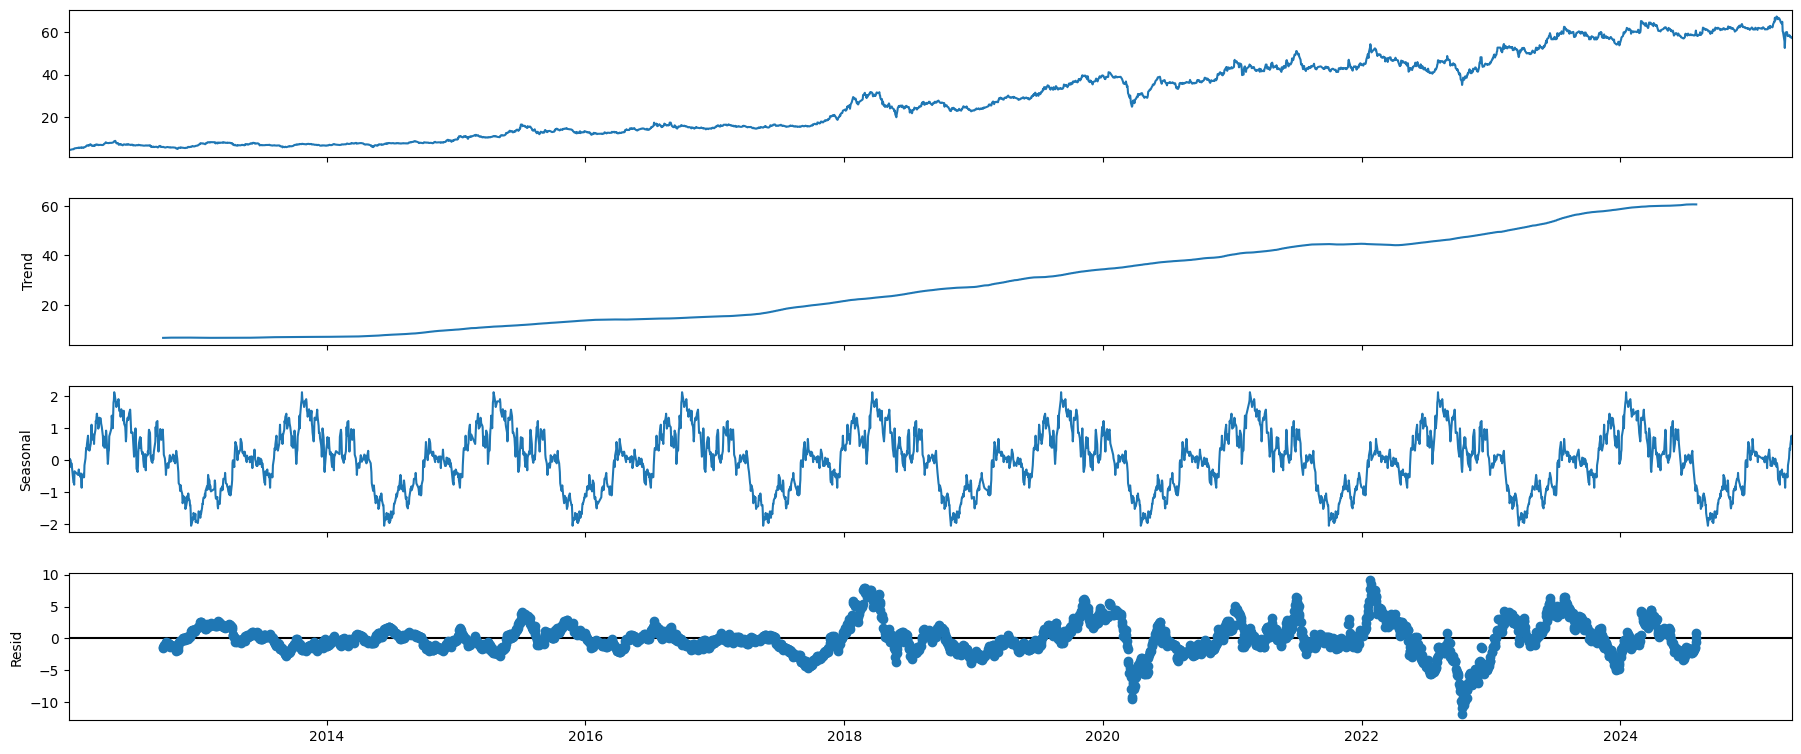

In [4]:
df_close = df[['date', 'close']].copy()
df_close = df_close.set_index('date')
df_close.head()

decomp = seasonal_decompose(df_close, period=365, model='additive')


fig = decomp.plot()
fig.set_size_inches(20, 8)

### Technical indicators

#### Moving Averages

I'm calculating few moving averages to be used as features: $SMA_{5}$, $SMA_{10}$, $SMA_{15}$, $SMA_{30}$ and $EMA_{9}$.

In [5]:
df['EMA_9'] = df['close'].ewm(9).mean().shift()
df['SMA_5'] = df['close'].rolling(5).mean().shift()
df['SMA_10'] = df['close'].rolling(10).mean().shift()
df['SMA_15'] = df['close'].rolling(15).mean().shift()
df['SMA_30'] = df['close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.date, y=df.close, name='Close', opacity=0.2))
fig.show()

#### Relative Strength Index

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [6]:
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.date, y=df.RSI, name='RSI'))
fig.show()

#### MACD

In [7]:
EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Shift label column

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [8]:
df['close'] = df['close'].shift(-1)

### Drop invalid samples

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [9]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

Here I split stock data frame into three subsets: training ($70\%$), validation ($15\%$) and test ($15\%$) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [10]:
test_size  = 0.1
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.date, y=valid_df.close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.close,  name='Test'))
fig.show()

### Drop unnecessary columns

In [11]:
drop_cols = ['date', 'volume', 'open', 'low', 'high']

train_df = train_df.drop(columns = drop_cols)
valid_df = valid_df.drop(columns = drop_cols)
test_df  = test_df.drop(columns = drop_cols)

### Split into features and labels

In [12]:
y_train = train_df['close'].copy()
X_train = train_df.drop(columns = ['close'])

y_valid = valid_df['close'].copy()
X_valid = valid_df.drop(columns = ['close'])

y_test  = test_df['close'].copy()
X_test  = test_df.drop(columns = ['close'])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        2466 non-null   float64
 1   SMA_5        2466 non-null   float64
 2   SMA_10       2466 non-null   float64
 3   SMA_15       2466 non-null   float64
 4   SMA_30       2466 non-null   float64
 5   RSI          2466 non-null   float64
 6   MACD         2466 non-null   float64
 7   MACD_signal  2466 non-null   float64
dtypes: float64(8)
memory usage: 154.2 KB


### Fine-tune XGBoostRegressor

In [13]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

# Create the base model without eval_set
model = xgb.XGBRegressor(objective='reg:squarederror')

# Configure GridSearchCV with evaluation set through fit_params
clf = GridSearchCV(model, parameters)

# Pass eval_set through fit parameters
clf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 200, 'random_state': 42}
Best validation score = 0.5646062358135963
CPU times: total: 1h 28min 43s
Wall time: 6min 5s


In [14]:
%%time
eval_set = [(X_valid, y_valid)]
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: total: 5.78 s
Wall time: 377 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.01, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

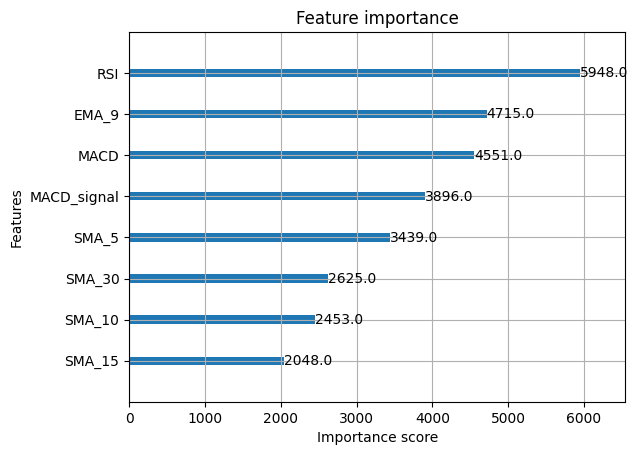

In [15]:
plot_importance(model);

### Calculate and visualize predictions

In [16]:
y_pred = model.predict(X_test)
y_pred = y_pred + 14
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [53.7127 55.8532 56.5221 57.4585 57.6592]
y_pred = [58.004166 57.99643  58.400246 59.614708 59.897694]


In [17]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 4.838731320030421


In [18]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=predicted_prices.close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()